# Scalabilty Evaluation

Evalutaing the ability of control approach to scale to the control of multiple basins

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import glob
import pandas as pd
import numpy as np
from pystorms.scenarios import gamma

In [20]:
def extract_performance(controller, path=".", seed=None):
    metrics = {"time": [], "performance": [], "control_points": [], "iterations": [], 'completed': []}
    # query all the files with controller names
    if seed is None:
        reports = glob.glob(path + "/*?[_" + str(controller) + "_]_Scalability_report.txt")
    else:
        reports = glob.glob(path + str(seed) +"_" + str(controller) + "_Scalability_report.txt")
    # parse them to find the compute time and performance for each controller
    for file in reports:
        # open the file
        with open(file, "r") as f:
            content = f.readlines()
        for line in content:
            # if line has optimization time, extract time and append it to array
            if bool(re.match(r"Optimization time:", line)):
                metrics["time"].append(
                    float(re.search(r"\d+\.?\d*", line).__getitem__(0)) / 60.0
                )
            # if line has performance
            if bool(re.match(r"Value at minimum:", line)):
                metrics["performance"].append(
                    float(re.search(r"\d+\.?\d*", line).__getitem__(0))
                )
                        # if line has performance
            if bool(re.match(r"Optimization completed:", line)):
                metrics["iterations"].append(
                    float(re.search(r"\d+\.?\d*", line).__getitem__(0))
                )
                idic_yes = re.search(r'\bYES\b', line)
                if (idic_yes != None):
                    metrics["completed"].append(1)
                else:
                    metrics["completed"].append(0)
                    
        metrics["control_points"].append(controller)
    return metrics

In [92]:
# Get the performamce metrics for all the data
controllers = np.linspace(1, 11, 11, dtype=int)
performance = {}
for i in controllers:
    performance[str(i)] = extract_performance(i, "./simulation-data/")

# Create them into a dataframe
simdata = pd.concat(
    [pd.DataFrame.from_dict(performance[i]) for i in performance.keys()],
    ignore_index=True,
)

In [77]:
# Estimate the no control performance and then normalize
# Create gamma scenario
def GammaData(actions):
    env = gamma()
    done = False
    # Modify the logger function to store depths
    env.data_log["depthN"] = {}
    for i in np.linspace(1, len(actions), len(actions), dtype=int):
        env.data_log["depthN"][str(i)] = []
    for i in np.linspace(len(actions) + 1, 11, 11 - len(actions), dtype=int):
        del env.data_log["flow"]["O" + str(i)]
        del env.data_log["flooding"][str(i)]
    while not done:
        done = env.step(actions)
    return env.data_log


def f_loss(x):
    data = GammaData(x[0])

    # Convert to pandas dataframes
    depths = pd.DataFrame.from_dict(data["depthN"])
    flows = pd.DataFrame.from_dict(data["flow"])
    flooding = pd.DataFrame.from_dict(data["flooding"])

    loss = 0.0
    flooding = flooding.gt(0.0)
    flooding = flooding.any()
    if flooding.any():
        loss += 10 ** 5

    flows = flows.sub(4.0)
    flows[flows < 0.0] = 0.0
    loss += flows.sum().sum()

    for i in depths.values[-1]:
        if i > 0.1:
            loss += i * 10 ** 4
    return loss

In [84]:
uncontrolled = {}
for i in range(1, 12):
    uncontrolled[str(i)] = f_loss(np.ones((1,i)))

In [101]:
# bin each controller
contol_performance = {}
for i in range(1,12):
    contol_performance[str(i)] = simdata[simdata["control_points"] == i]

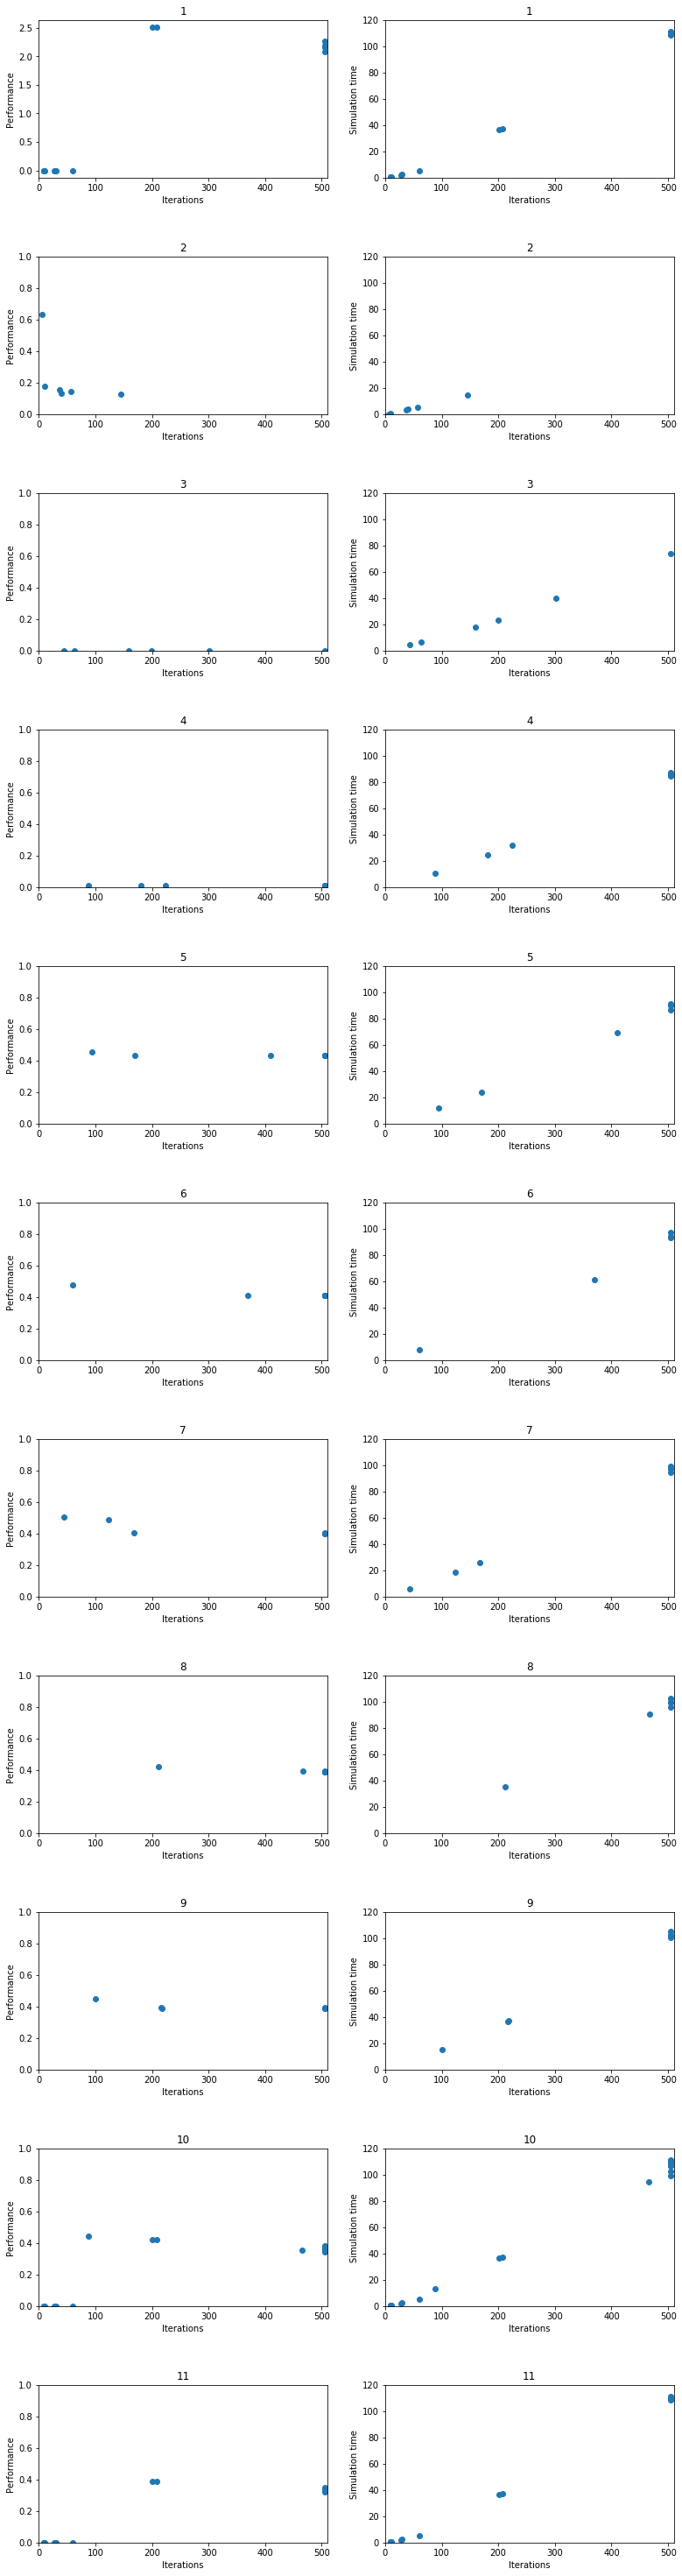

In [106]:
plt.figure(figsize=(13,40))
plt.subplots_adjust(bottom=0.0,top=1.0,hspace = 0.5)
counter = 1
for i in range(1,12):
    plt.subplot(11, 2, counter)
    plt.plot(contol_performance[str(i)]["iterations"].values, contol_performance[str(i)]["performance"].values/uncontrolled[str(i)], 'o')
    plt.xlabel("Iterations")
    plt.ylabel("Performance")
    plt.xlim([0, 510])
    if i != 1:
        plt.ylim([0, 1])
    plt.title(str(i))
    counter += 1
    plt.subplot(11, 2, counter)
    plt.plot(contol_performance[str(i)]["iterations"].values, contol_performance[str(i)]["time"].values, 'o')
    plt.xlabel("Iterations")
    plt.ylabel("Simulation time")
    plt.ylim([0, 120])
    plt.xlim([0, 510])
    plt.title(str(i))
    counter += 1

## Notes

1. As the number of basins increases, simulation time remains consistent. As dimention of the controllers does not impact each simulation. We only have to worry about number of iterations.
2. Random Seed becomes important as the number of controllers increases. Look the performances converges for lower dimensions and the dimensions increase, it becomes dependent on the random seed. 
3. Controller is able to improve the performance of the systems as number of controllers increase.

Todo:

1. Run them once again, to remove anamolies. Check the first basin example
2. Common metric 
3. As the number of controllers increase, how long does it take to converge. 